In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
import numpy as np
import pandas as pd

#models
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA


from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#for CV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV #CV?

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#model comparison
from sklearn import model_selection
from sklearn.metrics import confusion_matrix


# Loading the data

In [ ]:
df = pd.read_csv('./data/sleepdata.csv',delimiter=";")
df

We display the  data

In [ ]:
df.info()

In [ ]:
df.head()

As we can see in the graph the columns "heart rate" and "Wake up" are mostly null. However, the wake up column is not important for predicting the result of sleep quality. Because the mood when you wake up is a consequence of the sleep quality and not the opposite and the heart rate is 86% null values so it is not possible to extract information from that column.

# Cleaning the data

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

As we can see in the graph the columns “heart rate” and “Wake up” are mostly null. However, the wake up column is not important for predicting the result of sleep quality. Because the mood when you wake up is a consequence of the sleep quality and not the opposite and the heart rate is 86% null values so it is not possible to extract information from that column.

In [ ]:
#Drop the columns 'Wake up' and 'Heart rate'
df_cleaned=df.drop(columns=['Wake up','Heart rate'])

Another colum with lots of nulls is the column sleep notes but in this case null means that there are no extra notes for that nigth.

In [ ]:
df_cleaned['Sleep Notes'].fillna(value = '', inplace = True)

In [ ]:
sns.heatmap(df_cleaned.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

Transforming the 'Start' and 'End' columns to datetime type and the 'Time in bed' to seconds.

In [ ]:
df_cleaned['Start'] = pd.to_datetime(df_cleaned['Start'])
df_cleaned['End'] = pd.to_datetime(df_cleaned['End'])
df_cleaned['Time in bed'] = (df_cleaned['End'] - df_cleaned['Start']).astype('timedelta64[s]')
df_cleaned['Sleep quality'] = df_cleaned['Sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
df_cleaned['Start time'] = pd.Series([val.time() for val in df_cleaned['Start']])
df_cleaned['End time'] = pd.Series([val.time() for val in df_cleaned['End']])
df_cleaned['Start time in second'] = df_cleaned['Start'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df_cleaned['End time in second'] = df_cleaned['End'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)

In [ ]:
df_cleaned

In [ ]:
sleep_notes_values=np.unique(df_cleaned['Sleep Notes'].apply(lambda x: x.split(':')).sum())
sleep_notes_values=sleep_notes_values[1:]
print("All the different values for the Sleep notes: "+str(sleep_notes_values))

Transform the categorical of 'Sleep notes' into dummy/indicator variables.

In [ ]:
for v in sleep_notes_values:
    df_cleaned[v] = df_cleaned['Sleep Notes'].apply(lambda x: v in x).astype(int)

In [ ]:
df_cleaned

In [ ]:
grouped_df = df_cleaned[['Sleep quality', 'Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']].groupby(['Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']).mean()
grouped_df

Data grouped by the different sleeping

In [ ]:
df_cleaned['Day of week'] = [x.weekday() for x in df_cleaned['Start']]
df_cleaned_days_week=df_cleaned.copy()
df_cleaned_days_week['Day of week'] = df_cleaned['Day of week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

In [ ]:
sns.countplot(x = 'Day of week', hue = 'Worked out', data = df_cleaned_days_week).set(title='Working out in the week')

In [ ]:
sns.countplot(x = 'Day of week', hue = 'Drank coffee', data = df_cleaned_days_week).set(title='Working out in the week')

In [ ]:
sns.countplot(x = 'Day of week', hue = 'Drank tea', data = df_cleaned_days_week).set(title='Drinking tea out in the week')

In [ ]:
sns.countplot(x = 'Day of week', hue = 'Ate late', data = df_cleaned_days_week).set(title='Eating late in the week')

In [ ]:
sns.countplot(x = 'Day of week', hue = 'Stressful day', data = df_cleaned_days_week).set(title='Stressful day in the week')

In [ ]:
final_dataset=df_cleaned[['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day','Day of week']]
final_dataset.info()

In [ ]:
y=df_cleaned['Sleep quality']
X=final_dataset.values
labels=['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day','Day of week']

In [ ]:
for i in range(len(labels)):
    feat=labels[i]
    fig, ax = plt.subplots(1,2)
    ax[0].boxplot(X[:,i])
    ax[1].hist(X[:,i])
    ax[0].set_title(feat)
    plt.show()

In [ ]:
sns.heatmap(df_cleaned.corr()).set(title='Correlation matrix of the final data')

In [ ]:
#Scaling the data
scaler = StandardScaler()

standardized_X = scaler.fit_transform(X)

print(X)
print("####")
print(standardized_X.mean(axis=1), standardized_X.std(axis=1))

We have done PCA and association rules despite we didn't include this in the project report.

# PCA

In [ ]:
y_bins=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)

n_components=2
pca = PCA(n_components=n_components)

pca_features = pca.fit_transform(standardized_X)

print('Shape before PCA: ', standardized_X.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2'])

target_names = {
    0:"Between 0 and 25",
    1:"Between 26 and 50",
    2:"Between 51 and 75",
    3:"Between 76 and 100"
}

pca_df['target'] = y_bins
pca_df['target'] = pca_df['target'].map(target_names)

print(pca_df.head())

In [ ]:
sns.set()

sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,
    legend=True,
)

plt.title('2D PCA Graph')
plt.show()

In [ ]:
loadings = pca.components_

n_features = pca.n_features_

feature_names = labels

pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

xs = loadings[0]
ys = loadings[1]

for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0,
        xs[i],
        ys[i],
        color='r',
        head_width=0.01
    )
    plt.text(xs[i], ys[i], varnames)

xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('2D Loading plot with vectors')
plt.show()

# Association rules

In [ ]:
rules_dataset=final_dataset.copy()
rules_dataset['Sleep quality']=df_cleaned['Sleep quality']

In [ ]:
scaled_features_df = pd.DataFrame(standardized_X, index=final_dataset.index, columns=final_dataset.columns)

In [ ]:
rules_dataset["Sleep quality"]=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)
target_names = {
    0:"Between 0 and 25",
    1:"Between 26 and 50",
    2:"Between 51 and 75",
    3:"Between 76 and 100"
}
rules_dataset["Sleep quality"]=rules_dataset["Sleep quality"].map(target_names)

In [ ]:
rules_dataset

In [ ]:
rules_dataset['Sleep quality'].hist()

In [ ]:
rules_dataset=pd.get_dummies(rules_dataset,columns=['Sleep quality'])
rules_dataset=rules_dataset.drop(['Start time in second','End time in second','Time in bed','Activity (steps)','Day of week'],axis=1)

In [ ]:
er = apriori(rules_dataset, min_support = 0.1, use_colnames = True, verbose = 1)
df_ar = association_rules(er, metric = "confidence", min_threshold = 0.2)
df_ar

# CV

In [468]:
##### Warnings, maybe not have ?
import warnings
warnings.filterwarnings('ignore')

In [469]:
#for testing the code:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

In [470]:
#our values standardized
X=scaled_features_df.values
y=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)
bin_counts = y.value_counts().sort_index()
print(bin_counts)

0     22
1     22
2    356
3    487
Name: Sleep quality, dtype: int64


#### One iteration:

In [471]:
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
nb_model=GaussianNB().fit(x_train, y_train,sample_weight)
sv_model = SVC(class_weight='balanced').fit(x_train, y_train)
dt_model=DecisionTreeClassifier(class_weight='balanced').fit(x_train, y_train)

print(dt_model.score(x_test,y_test),
      sv_model.score(x_test,y_test),
      nb_model.score(x_test,y_test),
      knn_model.score(x_test,y_test))


0.5802047781569966 0.5870307167235495 0.09556313993174062 0.5733788395904437


## CV, before tuning

In [472]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]

In [473]:
for i in range(100):
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
    sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

    """Fitting each model"""
    knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
    nb_model=GaussianNB().fit(x_train, y_train,sample_weight)
    sv_model = SVC(class_weight='balanced').fit(x_train, y_train)
    dt_model=DecisionTreeClassifier(class_weight='balanced').fit(x_train, y_train)

    """Appending accuracy""" 
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))

accuracies=(accuracy_list_K_nearest_neighbor,
    accuracy_list_naive_bayes,
    accuracy_list_support_vector,
    accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')

 accuracy for k-nn is: 0.6031026330410344
 accuracy for support vectors is: 0.5953451565738435
 accuracy for naive bayes is: 0.08766396841034275
 accuracy for decision trees is: 0.5819730789736471
 mean accuracy is: 0.4670212092497169
 best accuracy is: 0.6031026330410344


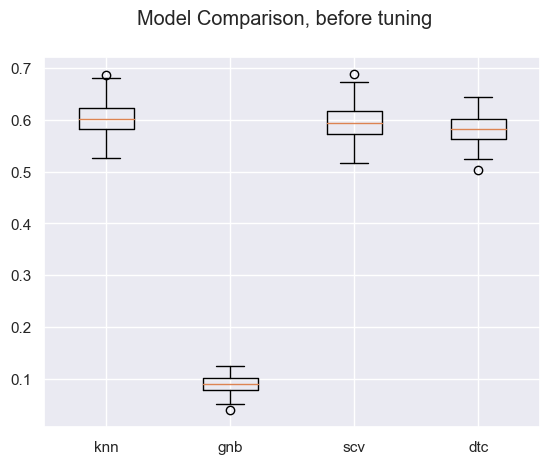

In [474]:
variables=[['Start time in second'],
 ['End time in second'],
 ['Time in bed'],
 ['Activity (steps)'],
 ['Ate late'],
 ['Worked out'],
 ['Drank coffee'],
 ['Drank tea'],
 ['Stressful day'],
 ['Day of week']]

# accuracies
models=['knn','gnb','scv','dtc']
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison, before tuning')
ax = fig.add_subplot(111)
plt.boxplot(accuracies)
ax.set_xticklabels(models)
plt.show()

## Hyperparameterization

In [475]:
#decision trees

grid = {'criterion': ['gini', 'entropy', 'log_loss'],'splitter': ["best","random"],'min_samples_leaf':[1,2,3,4,5]}
classifier=DecisionTreeClassifier(random_state=42,class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test))
print(grid_search.best_params_,grid_search.score(x_test,y_test))

{'splitter': 'best', 'min_samples_leaf': 1, 'criterion': 'entropy'} 0.5443037974683544
{'criterion': 'gini', 'min_samples_leaf': 2, 'splitter': 'random'} 0.5864978902953587


In [ ]:
#knn, commented bc takes time
grid = {'n_neighbors' : np.random.randint(1,50,10),
         'weights':['uniform','distance'],
         'algorithm':['auto','ball_tree','kd_tree','brute'],
         'leaf_size':[int(x) for x in np.linspace(start = 0, stop = 300, num=10)],
         'p':[1,2,3,4,5]}
classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always

# """{'weights': 'distance', 'p': 4, 'n_neighbors': 30, 'leaf_size': 133, 'algorithm': 'ball_tree'} 0.8532423208191127
# {'algorithm': 'auto', 'leaf_size': 33, 'n_neighbors': 14, 'p': 1, 'weights': 'uniform'} 0.8532423208191127"""


In [ ]:
# SVC
# Error "X should be a square kernel matrix"? : ## Ok precomputed was the problem
grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'gamma': ['scale', 'auto'],'degree':[1,2,3,4]} # not inclded precomputed
classifier=SVC(class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always

# """{'kernel': 'linear', 'gamma': 'auto', 'degree': 3} 0.8498293515358362
# {'degree': 1, 'gamma': 'scale', 'kernel': 'linear'} 0.8498293515358362"""

In [ ]:
# #NB

weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

grid = {'var_smoothing': np.logspace(0,-9, num=100)}
classifier = GaussianNB()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train,sample_weight=sample_weight)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always

# """{'var_smoothing': 1.0} 0.8498293515358362
# {'var_smoothing': 1.0} 0.8498293515358362"""

## CV, after tuning

In [ ]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]

In [ ]:

for i in range(100): #Change after doing on real data 
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
    sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))
    """Fitting each model"""
    knn_model = KNeighborsClassifier(weights='uniform', p=1, n_neighbors= 29,
                                     leaf_size=33, algorithm='auto').fit(x_train, y_train)
    nb_model=GaussianNB(var_smoothing= 1.0,).fit(x_train, y_train,sample_weight)
    sv_model = SVC(degree=1, gamma='auto', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
    dt_model=DecisionTreeClassifier(criterion='entropy', min_samples_leaf= 1, splitter='best',class_weight='balanced').fit(x_train, y_train)

    """Appending accuracy"""
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))
accuracies=(accuracy_list_K_nearest_neighbor,
            accuracy_list_naive_bayes,
            accuracy_list_support_vector,
            accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')

In [ ]:
variables=[['Start time in second'],
 ['End time in second'],
 ['Time in bed'],
 ['Activity (steps)'],
 ['Ate late'],
 ['Worked out'],
 ['Drank coffee'],
 ['Drank tea'],
 ['Stressful day'],
 ['Day of week']]

# accuracies
models=['knn','gnb','scv','dtc']
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison, after tuning')
ax = fig.add_subplot(111)
plt.boxplot(accuracies)
ax.set_xticklabels(models)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

print("Distribution of data within bins:\n",bin_counts)

## classifiers, tuned. Already run above

# predicting for the test data
y_pred_svc = sv_model.predict(X_test)
y_pred_dtc = dt_model.predict(X_test)
y_pred_gnb = nb_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)


y_test = y_test.tolist()

predlist=[y_pred_svc, y_pred_dtc, y_pred_gnb, y_pred_knn]
clf_lst=['scv','dtc','gnb','knn']
target_names = {
    0:"Between 0 and 25",
    1:"Between 26 and 50",
    2:"Between 51 and 75",
    3:"Between 76 and 100"
}
for i, pred in enumerate(predlist):
    cm = confusion_matrix(y_test, pred)
    #print(cm)
    # Normalising
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f',xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True')
    plt.title(f'{clf_lst[i]}')
    plt.xlabel('Predicted')
    plt.show(block=False)


## Variable importance

In [ ]:
#np.random.seed(42) 

X_train,X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=np.random.uniform(low=0.2,high=0.35))


test_variables=[['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)'], ['Drank tea'],['Drank coffee'], ['Worked out'], ['Ate late'], ['Stressful day']]
accuracy_list_support_vector_exl=[]
accuracy_list_support_vector_incl=[]

sv_model_org = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(X_train, y_train)
org_score=sv_model_org.score(X_test,y_test)

for i in test_variables:
    x_train=X_train.drop(columns=i)
    x_test=X_test.drop(columns=i)    
    
    sv_model_e = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
    accuracy_list_support_vector_exl.append(sv_model_e.score(x_test,y_test))

for i in test_variables:
    x_train=X_train[i]
    x_test=X_test[i]

    sv_model_i = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
    accuracy_list_support_vector_incl.append(sv_model_i.score(x_test,y_test))

print(f"Original accuracy is {round(org_score,3)}")
for i,var in enumerate(test_variables):
    print(f'Variable "{var[0]}", accuracy when excluding is {round(accuracy_list_support_vector_exl[i],3)} and when excluding all else it is {round(accuracy_list_support_vector_incl[i],3)} ')

print(f"Original accuracy is {round(org_score,3)}")
for i,var in enumerate(test_variables):
    print(f'"{var[0]}" & {round(accuracy_list_support_vector_exl[i],3)} & {round(accuracy_list_support_vector_incl[i],3)} \\\ ')

print([x[0] for x in [['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)']]])

In [ ]:
import statistics

accuracy_list_exl=[]
accuracy_list_incl=[]
og_acc=[]
for _ in range(100):
    X_train,X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=np.random.uniform(low=0.2,high=0.35))


    test_variables=[['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)'], ['Drank tea'],['Drank coffee'], ['Worked out'], ['Ate late'], ['Stressful day']]
    accuracy_list_support_vector_exl=[]
    accuracy_list_support_vector_incl=[]

    sv_model_org = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(X_train, y_train)
    org_score=sv_model_org.score(X_test,y_test)
    og_acc.append(org_score)

    for i in test_variables:
        x_train=X_train.drop(columns=i)
        x_test=X_test.drop(columns=i)    

        sv_model_e = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
        accuracy_list_support_vector_exl.append(sv_model_e.score(x_test,y_test))

    for i in test_variables:
        x_train=X_train[i]
        x_test=X_test[i]

        sv_model_i = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
        accuracy_list_support_vector_incl.append(sv_model_i.score(x_test,y_test))
    
    accuracy_list_incl.append(accuracy_list_support_vector_incl)
    accuracy_list_exl.append(accuracy_list_support_vector_exl)
        

print(f"Original accuracy is {round(statistics.mean(og_acc),3)}, with a variance of {round(statistics.variance([item for item in og_acc]),3)}")
for i,var in enumerate(test_variables):
    print(f'"{var[0]}" & {round(statistics.mean([item[i] for item in accuracy_list_exl]),3)} & {round(statistics.mean([item[i] for item in accuracy_list_incl]),3)} &{round(statistics.variance([item[i] for item in accuracy_list_exl]),4)} &{round(statistics.variance([item[i] for item in accuracy_list_incl]),4)}\\\ ')


In [ ]:
import statistics

test_variables=variables #from the comparison, all variables 

accuracy_list_exl=[]
accuracy_list_incl=[]
og_acc=[]
for _ in range(100):
    X_train,X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=np.random.uniform(low=0.2,high=0.35))
    accuracy_list_support_vector_exl=[]
    accuracy_list_support_vector_incl=[]

    sv_model_org = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(X_train, y_train)
    org_score=sv_model_org.score(X_test,y_test)
    og_acc.append(org_score)

    for i in test_variables:
        x_train=X_train.drop(columns=i)
        x_test=X_test.drop(columns=i)    

        sv_model_e = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
        accuracy_list_support_vector_exl.append(sv_model_e.score(x_test,y_test))

    for i in test_variables:
        x_train=X_train[i]
        x_test=X_test[i]

        sv_model_i = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
        accuracy_list_support_vector_incl.append(sv_model_i.score(x_test,y_test))
    
    accuracy_list_incl.append(accuracy_list_support_vector_incl)
    accuracy_list_exl.append(accuracy_list_support_vector_exl)
        

print(f"Original accuracy is {round(statistics.mean(og_acc),3)}, with a variance of {round(statistics.variance([item for item in og_acc]),3)}")
for i,var in enumerate(test_variables):
    print(f'"{var[0]}" & {round(statistics.mean([item[i] for item in accuracy_list_exl]),3)} & {round(statistics.mean([item[i] for item in accuracy_list_incl]),3)} &{round(statistics.variance([item[i] for item in accuracy_list_exl]),4)} &{round(statistics.variance([item[i] for item in accuracy_list_incl]),4)}\\\ ')
